The script demonstrates how the code can be used with a toy example (see also [this blogpost](https://andreasloukas.blog/2018/11/05/multilevel-graph-coarsening-with-spectral-and-cut-guarantees/)).

The code accompanies paper [Graph reduction with spectral and cut guarantees](http://www.jmlr.org/papers/volume20/18-680/18-680.pdf) by Andreas Loukas published at JMLR/2019 ([bibtex](http://www.jmlr.org/papers/v20/18-680.bib)).

This work was kindly supported by the Swiss National Science Foundation (grant number PZ00P2 179981).

15 March 2019

[Andreas Loukas](https://andreasloukas.blog)

[![DOI](https://zenodo.org/badge/175851068.svg)](https://zenodo.org/badge/latestdoi/175851068)

Released under the Apache license 2.0

In [1]:
!pip install networkx

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/user/1348/ipykernel_2383576/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_utils

import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx
import pygsp as gsp
from pygsp import graphs
gsp.plotting.BACKEND = 'matplotlib'

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pygsp as pygsp
from pygsp import graphs, filters, reduction

from tqdm import tqdm
import numpy as np
import os
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    df = pd.read_csv(file)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls
def plot_graphnx(G, pos=None, edge_width=0.8, node_size=20, alpha=0.55, title=""):
    """
    Plot a single graph G using networkx.
    pos : dict, optional
        A dictionary with nodes as keys and positions as values.
        If not provided, will use spring layout.

    """
    if pos is None:
        pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d' if len(next(iter(pos.values()))) == 3 else None)
    ax.axis("off")
    ax.set_title(title)

    # Draw edges and nodes
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha, width=edge_width)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=alpha)

    fig.tight_layout()
    plt.savefig("test.png", format='png')
    plt.close(fig)

    return fig

In [13]:
# Extract to dataframe
import pygsp.graphs
import pygsp.graphs.graph


df = csv_to_df("./MSCallGraph_0.csv")

# Extract all tids
tids_list = df['traceid'].unique()
print("Num of tids: ", len(tids_list))

# Create edges & nodes list
all_edges = []
all_nodes = []
nodeid_map = {} # nodeid mappings to numeric indices & type
ctr = 0
for i in tqdm(range(len(tids_list))):
    ctr += 1
    tid_calls = extract_traceid_rows(df, tids_list[i])
    for call in tid_calls:
        all_edges.append([call.um, call.dm]) # creating edge
        if call.um not in nodeid_map:
            nodeid_map[call.um] = Node_info(0,0)
        if call.dm not in nodeid_map: # rpctype applies only for dm
            nodeid_map[call.dm] = Node_info(0, call.rpctype)
        elif nodeid_map[call.dm].n_type == 0:
            nodeid_map[call.dm].n_type = call.rpctype

    if ctr == 100: # exit after x traces
        break

# Give numeric ids to all nodes
all_nodes = list(nodeid_map.keys())
num_nodes = len(all_nodes)
print("Num nodes: ", num_nodes)
for i in range(len(all_nodes)):
    nodeid_map[all_nodes[i]].num_id = i
del all_nodes
# print(nodeid_map)

# Saving nodeid map and edgeslist


# Graph building (networkx)
G = nx.Graph()
G.add_edges_from(all_edges)
# pos = nx.spring_layout(G)
# coords = np.array([pos[i] for i in sorted(G.nodes())])
plot_graphnx(G)

for i in all_edges:
    i[0] = nodeid_map[i[0]].num_id
    i[1] = nodeid_map[i[1]].num_id
adjacency_matrix = np.zeros((num_nodes, num_nodes))
for i in all_edges:
    adjacency_matrix[i[0], i[1]] = 1
    adjacency_matrix[i[1], i[0]] = 1

G_gsp = pygsp.graphs.Graph(adjacency_matrix)

Num of tids:  130512


  0%|          | 99/130512 [00:24<8:52:15,  4.08it/s]


Num nodes:  196


2024-07-01 17:38:52,279:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


### Construct the graph ## 

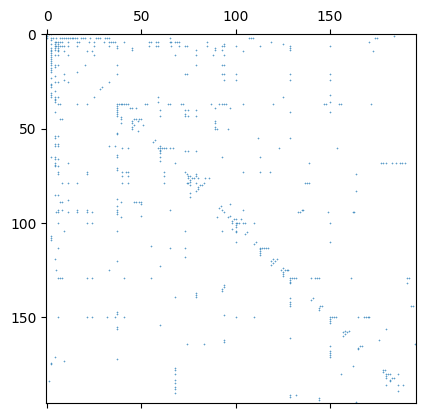

In [14]:
G = G_gsp
if not hasattr(G, 'coords'): 
    try:
        graph = nx.from_scipy_sparse_array(G.W)
        pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')  
        G.set_coordinates(np.array(list(pos.values()))) 
    except ImportError:
        G.set_coordinates()
    G.compute_fourier_basis() # this is for convenience (not really needed by coarsening)
    
N = G.N
L = G.L.toarray()
S = graph_coarsening.graph_utils.get_S(G).T

plt.spy(G.W, markersize=0.2);

### Do some coarsening

* Possible methods supported are: 'variation_edges', 'variation_neighborhood', 'algebraic_JC', 'heavy_edge', 'affinity_GS'
* $r = 1 - n/N$ is the dimensionality reduction ratio
* $k$ is the size of the subspace we are interested in
* $k_{max}$ should be set to be larger or equal to $k$. It allows us to measure the quality of coarsening over subspaces larger than $k$.

In [32]:
method = 'variation_neighbourhood'  

# Parameters
r    = 0.7 # the extend of dimensionality reduction (r=0 means no reduction)
k    = 5  
kmax = int(3*k)
        
C, Gc, Call, Gall = coarsen(G, K=k, r=r, method=method) 
# metrics = coarsening_quality(G, C, kmax=kmax)
n = Gc.N

print(len(Gall))

# print('{:16} | r: {:1.4}, nedges: {}, levels: {}, epsilon: {:1.4}'.format(method, metrics['r'], metrics['m'], len(Call), metrics['error_subspace'][k-1]))

1


### Visualize the sequence of coarsening levels

* $c+1$ graphs are plotted in total. The leftmost is the original graph and the rightmost is the final coarse graph. 
* Colors are used to indicate the size of each contraction set $C$: 
    * green is for $|C|=2$  blue is for $|C|=3$, red is for $|C|=4$, and yellow for $|C|>4$


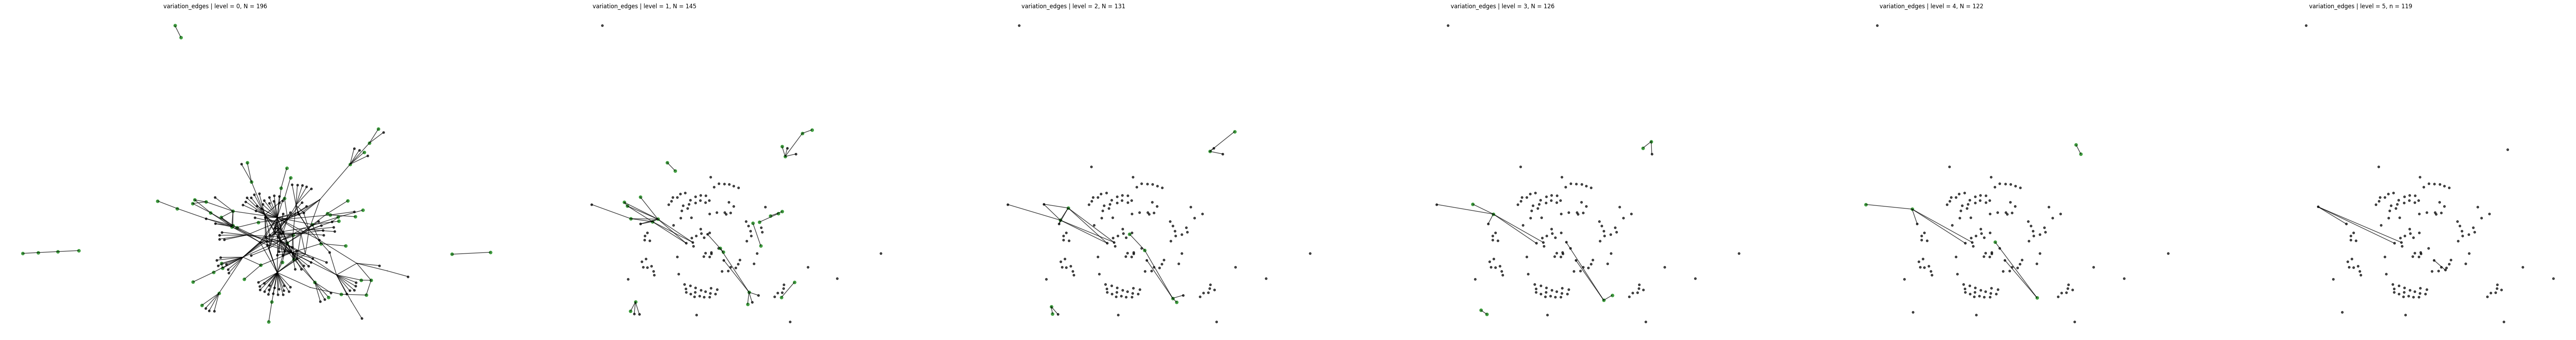

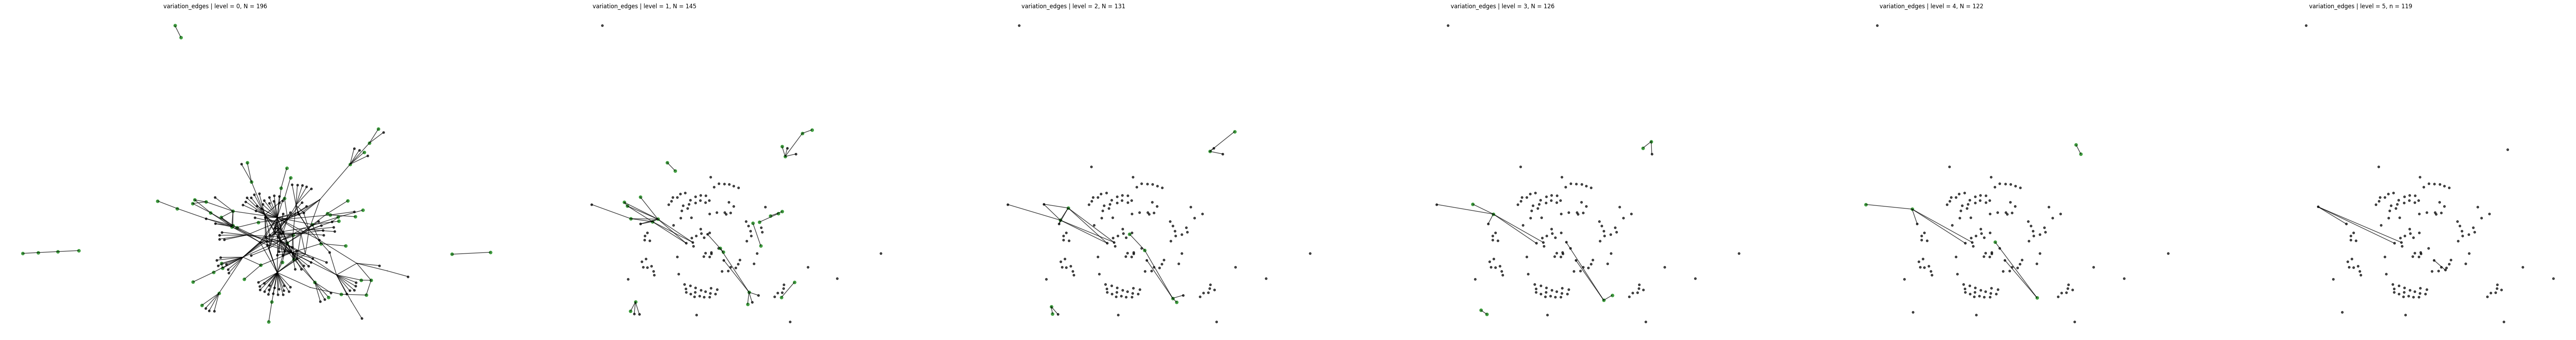

In [30]:
plot_coarsening(Gall, Call, size=5, alpha=0.7, title=method)

### Various metrics for coarsening quality

* $\epsilon$ is the restricted similarity constant such that, for every $x \in span(U_k)$ we have $$(1 - \epsilon) x^\top L x \leq x_c^\top L_c x_c \leq (1+\epsilon) x^\top L x $$   
* the eigenvalue error is defined (for every $i = 1, \ldots, k, \ldots, kmax$ as $\frac{\lambda_i - \tilde{\lambda}_i}{\lambda_i}$
* the angle matrix contains the angles between the eigenvectors of $L$ (y-axis) and the lifted eigenvectors of $L_c$. The closer to counter-diagonal it is, the better.

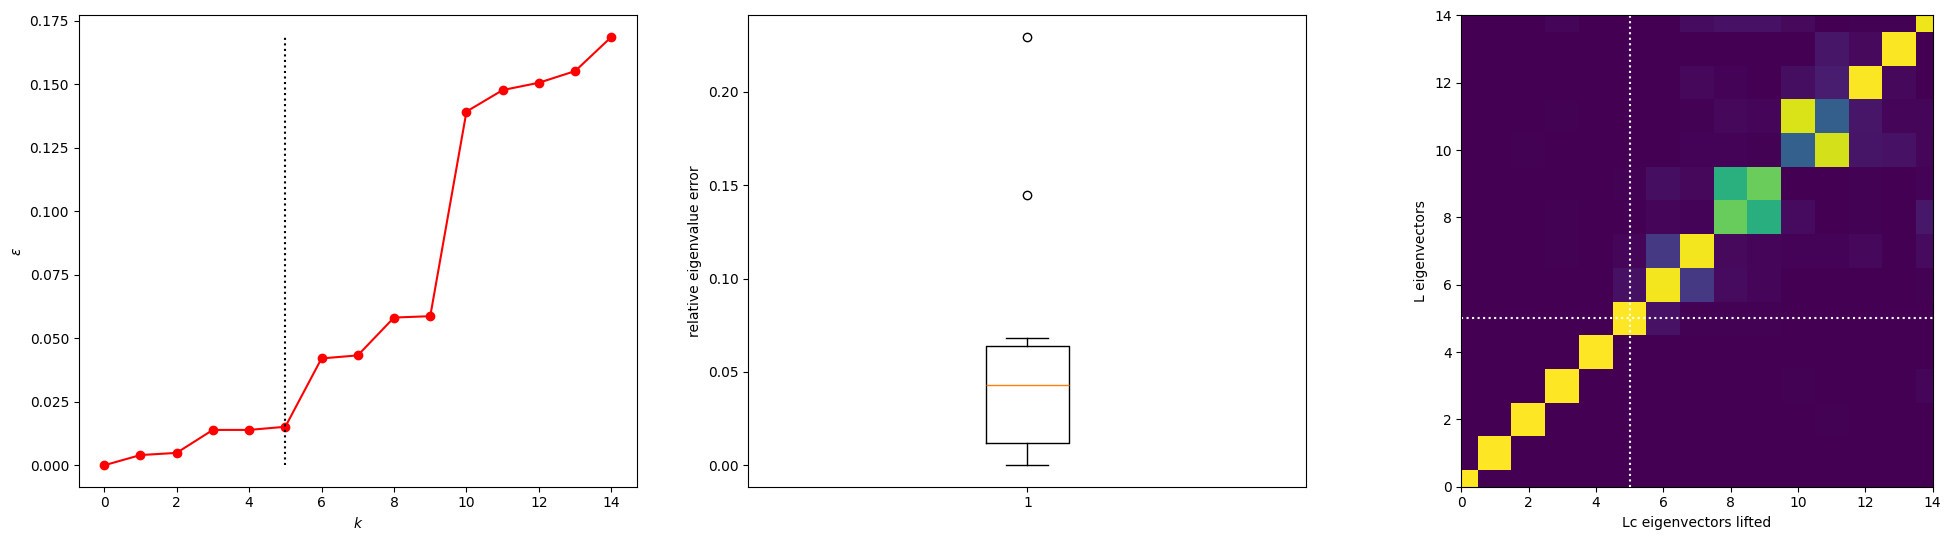

In [54]:
size = 2.04; fig, axes = plt.subplots(1, 3, figsize=(4*size*3, 3*size)); lineWidth = 1

axes[0].plot(np.arange(kmax), np.abs(metrics['error_subspace']), 'or-') 
axes[0].set_xlabel('$k$'); axes[0].set_ylabel('$\epsilon$')
axes[0].plot( [k, k], [0, max(metrics['error_subspace'])], ':k') 

axes[1].boxplot(np.abs(metrics['error_eigenvalue'])) 
axes[1].set_ylabel('relative eigenvalue error')

axes[2].imshow(abs(metrics['angle_matrix'][:,0:kmax]) )
axes[2].plot( [k, k], [0, kmax], ':w') 
axes[2].plot( [0, kmax], [k, k], ':w') 
axes[2].plot( [0, N], [n-1, n-1], ':w') 
axes[2].set_xlim([0, kmax-1])
axes[2].set_ylim([0, kmax-1])
axes[2].set_xlabel('Lc eigenvectors lifted'); axes[2].set_ylabel('L eigenvectors');

### Coarsen and lift a vector

In [ ]:
size = 2.04; fig, axes = plt.subplots(1, 4, figsize=(4*size*4, 3*size)); lineWidth = 1

# a random smooth signal 
x = G.U[:,:k] @ np.random.randn(k,1)
x = x / np.linalg.norm(x)
G.plot_signal(x, ax=axes[0], plot_name='signal')

# coarsen it 
xc = coarsen_vector(x, C)
Gc.plot_signal(xc, ax=axes[1], plot_name='coarsened signal')

# lift it 
xp = lift_vector(xc, C)
G.plot_signal(xp, ax=axes[2], plot_name='lifted signal')

# difference
G.plot_signal(np.abs(x-xp), ax=axes[3], plot_name='|x - xp|')

print('signal error: {}'.format(np.linalg.norm(x - xp)))